In [1]:
%matplotlib notebook
%matplotlib inline

import os

import numpy as np
import pandas as pd
from pandas import DataFrame as df

from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.animation import FuncAnimation

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import torch

from tqdm.notebook import tqdm

- [ ] GMM IoU wrt PL Modeling with 1 component
- [x] GMM IoU wrt PL Modeling with 2 components
- [ ] GMM Score Modeling

## function calls

In [2]:
def mmd_loss(x, y, sigma2=1):
    x_kernel = torch.exp(-torch.square(x.unsqueeze(1) - x.unsqueeze(0)) / (2 * sigma2))
    y_kernel = torch.exp(-torch.square(y.unsqueeze(1) - y.unsqueeze(0)) / (2 * sigma2))
    xy_kernel = torch.exp(-torch.square(x.unsqueeze(1) - y.unsqueeze(0)) / (2 * sigma2))
    loss = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return loss

In [3]:

def gather_stats(stats, batch_type='unlab', WINDOW_SIZE=64):
    max_iou_after_subsampling_stats_dict = {
    'classwise_max_iou_afs_Car': stats[f'classwise_{batch_type}_max_iou_afs_Car'],
    'classwise_max_iou_afs_Pedestrian': stats[f'classwise_{batch_type}_max_iou_afs_Pedestrian'],
    'classwise_max_iou_afs_Cyclist': stats[f'classwise_{batch_type}_max_iou_afs_Cyclist'],
    'iteration' : stats[f'classwise_{batch_type}_max_iou_afs_iteration']
    }
    max_iou_before_subsampling_stats_dict = {
        'classwise_max_iou_bfs_Car': stats[f'classwise_{batch_type}_max_iou_bfs_Car'],
        'classwise_max_iou_bfs_Pedestrian': stats[f'classwise_{batch_type}_max_iou_bfs_Pedestrian'],
        'classwise_max_iou_bfs_Cyclist': stats[f'classwise_{batch_type}_max_iou_bfs_Cyclist'],
        'iteration' : stats[f'classwise_{batch_type}_max_iou_bfs_iteration']
    }
    try:
        class_labels = stats['roi_labels']
    except KeyError:
        class_labels = stats['class_labels']
    
    stats_dict = {
        'iou_roi_gt': stats['iou_roi_gt'],
        'iou_roi_pl': stats['iou_roi_pl'],
        'iteration' : stats['iteration'],
        'class_labels': class_labels,
        'pred_scores': stats['pred_scores'],
        'roi_scores' : stats['roi_scores']
    }

    if 'iou_local_thresh_Car' in stats:
        stats_dict.update(**{'iou_local_thresh_Car': stats['iou_local_thresh_Car'],
            'iou_local_thresh_Pedestrian': stats['iou_local_thresh_Pedestrian'],
            'iou_local_thresh_Cyclist': stats['iou_local_thresh_Cyclist']})

    stats_afs_df = pd.DataFrame(max_iou_after_subsampling_stats_dict)
    stats_bfs_df = pd.DataFrame(max_iou_before_subsampling_stats_dict)
    stats_df = pd.DataFrame(stats_dict)
    stats_afs_df['iteration'] = stats_afs_df['iteration'].astype('int32')
    stats_bfs_df['iteration'] = stats_bfs_df['iteration'].astype('int32')
    stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
    stats_df['iteration'] = stats_df['iteration'].astype('int32')

    #num_windows = stats_afs_df.iteration.max() // WINDOW_SIZE + 1
    #num_windows = stats_bfs_df.iteration.max() // WINDOW_SIZE + 1


    num_windows = stats_df.iteration.max() // WINDOW_SIZE + 1
    stats_bfs_df['window'] = (stats_bfs_df['iteration']) // WINDOW_SIZE
    stats_afs_df['window'] = (stats_afs_df['iteration']) // WINDOW_SIZE
    stats_df['window'] = (stats_df['iteration']) // WINDOW_SIZE
    stats_df['type'] = 'none'


    return stats_bfs_df, stats_afs_df, stats_df, num_windows


# PARAMETERES

In [4]:



fg_gt_thresh = [0.7, 0.5, 0.5]
fg_pl_thresh = [0.50, 0.45, 0.4]
pre_filtering_thresh = 0.1
cls_names = ['Car', 'Pedestrian', 'Cyclist']

HIST_BIN = np.linspace(pre_filtering_thresh, 1, 20)

# tp fp
palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
ERROR_HIST_ARGS_COUNT = dict(hue='type', stat='count',bins=HIST_BIN, fill=True, alpha=0.6, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
ERROR_HIST_ARGS_PROP =  dict(hue='type', multiple='stack', stat='proportion',bins=HIST_BIN, fill=True, alpha=0.6, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])


# subsampling
SS_HIST_ARGS_COUNT = dict(fill=True, legend=True, bins=HIST_BIN, alpha=0.6, stat='count', hue_order=['tp', 'fp', 'fn', 'tn'])
SS_HIST_ARGS_PROP = dict(fill=True, legend=True, bins=HIST_BIN, alpha=0.6,  stat='proportion', hue_order=['tp', 'fp', 'fn', 'tn'])



In [5]:
##############################################

ENABLE_PLOTS=True

#############################################


# # pretraining
# exp_name='pretrain_split_0.01_1_rpn_entropy'
# lbld_path = os.path.join(os.getcwd(),"../output/cfgs/kitti_models/pv_rcnn/base_focal_entropy/", exp_name,'scores_lbd.pkl')
# stats_lbd = pd.read_pickle(lbld_path)




# second stage
exp_name='baseline_split_0.01_1_8773ad2'
lbld_path = os.path.join(os.getcwd(),"../output/cfgs/kitti_models/pv_rcnn_ssl_60/base_focal_entropy/", exp_name,'scores_lbd.pkl')
unlbld_path = os.path.join(os.getcwd(),"../output/cfgs/kitti_models/pv_rcnn_ssl_60/base_focal_entropy/", exp_name,'scores_unlbd.pkl')
stats_lbd = pd.read_pickle(lbld_path)
stats_unlbd = pd.read_pickle(unlbld_path)




In [6]:
for key, val in stats_unlbd.items():
    print(key, len(val))

iou_roi_pl 713216
iou_roi_gt 713216
pred_scores 713216
iteration 713216
roi_labels 713216
roi_scores 713216
classwise_unlab_max_iou_bfs_iteration 2856960
classwise_unlab_max_iou_bfs_Car 2856960
classwise_unlab_max_iou_bfs_Pedestrian 2856960
classwise_unlab_max_iou_bfs_Cyclist 2856960
classwise_unlab_max_iou_afs_iteration 714240
classwise_unlab_max_iou_afs_Car 714240
classwise_unlab_max_iou_afs_Pedestrian 714240
classwise_unlab_max_iou_afs_Cyclist 714240


In [7]:
for key, val in stats_lbd.items():
    print(key, len(val))

iou_roi_pl 714240
iou_roi_gt 714240
pred_scores 714240
iteration 714240
roi_labels 714240
roi_scores 714240
classwise_lab_max_iou_bfs_iteration 2856960
classwise_lab_max_iou_bfs_Car 2856960
classwise_lab_max_iou_bfs_Pedestrian 2856960
classwise_lab_max_iou_bfs_Cyclist 2856960
classwise_lab_max_iou_afs_iteration 714240
classwise_lab_max_iou_afs_Car 714240
classwise_lab_max_iou_afs_Pedestrian 714240
classwise_lab_max_iou_afs_Cyclist 714240


In [8]:
BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 8
stats_bfs_df_unlab, stats_afs_df_unlab, stats_df_unlab, num_windows_unlab = gather_stats(stats_unlbd, batch_type='unlab', WINDOW_SIZE=WINDOW_SIZE)
stats_bfs_df_lab, stats_afs_df_lab, stats_df_lab, num_windows_lab = gather_stats(stats_lbd, batch_type='lab', WINDOW_SIZE=WINDOW_SIZE)

In [9]:

SAVE_DIR = os.path.join(os.getcwd(), 'anims', exp_name)
os.makedirs(SAVE_DIR, exist_ok=True)


anim_lab_subsample_hist_proportion = os.path.join(SAVE_DIR, f'subsample_lab_{exp_name}_ws{WINDOW_SIZE}_proportion.gif')
anim_lab_subsample_hist_count = os.path.join(SAVE_DIR, f'subsample_lab_{exp_name}_ws{WINDOW_SIZE}_count.gif')
anim_lab_error_hist_proportion = os.path.join(SAVE_DIR, f'error_lab_{exp_name}_ws{WINDOW_SIZE}_proportion.gif')
anim_lab_error_hist_count = os.path.join(SAVE_DIR, f'error_lab_{exp_name}_ws{WINDOW_SIZE}_count.gif')
#anim_lab_error_plot = os.path.join(SAVE_DIR, f'error_lab_{exp_name}_ws{WINDOW_SIZE}_plot.gif')

anim_unlab_subsample_hist_proportion = os.path.join(SAVE_DIR, f'subsample_unlab_{exp_name}_ws{WINDOW_SIZE}_proportion.gif')
anim_unlab_subsample_hist_count = os.path.join(SAVE_DIR, f'subsample_unlab_{exp_name}_ws{WINDOW_SIZE}_count.gif')
anim_unlab_error_hist_proportion = os.path.join(SAVE_DIR, f'error_unlab_{exp_name}_ws{WINDOW_SIZE}_proportion.gif')
anim_unlab_error_hist_count = os.path.join(SAVE_DIR, f'error_unlab_{exp_name}_ws{WINDOW_SIZE}_count.gif')
#anim_unlab_error_plot = os.path.join(SAVE_DIR, f'error_unlab_{exp_name}_ws{WINDOW_SIZE}_plot.gif')




anim_lab_unlab_proportion = os.path.join(SAVE_DIR, f'lab_unlab_{exp_name}_ws{WINDOW_SIZE}_proportion.gif')
anim_lab_unlab_proportion_mmd = os.path.join(SAVE_DIR, f'lab_unlab_{exp_name}_ws{WINDOW_SIZE}_proportion_mmd.gif')
anim_lab_unlab_count = os.path.join(SAVE_DIR, f'lab_unlab_{exp_name}_ws{WINDOW_SIZE}_count.gif')

## Error Plots (tp, fp)

In [10]:
def update(w):
    global stat_
    global batch_type

    if batch_type in ['unlab']:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_unlab, stats_afs_df_unlab, stats_df_unlab
    else:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_lab, stats_afs_df_lab, stats_df_lab
    
    if stat_ in ['proportion']:
        ARGS = ERROR_HIST_ARGS_PROP.copy()
        y_text = -0.02
        max_y_limit = 0.2
    elif stat_ in ['count']:
        ARGS = ERROR_HIST_ARGS_COUNT.copy()
        y_text = -100
        max_y_limit = 1000
    else:
        raise NotImplemented

    window_df = stats_df.groupby("window").get_group(w)
    for cind, class_name in enumerate(cls_names):
        cls_df = window_df[window_df['class_labels'] == cind+1]

        gt_score = cls_df['iou_roi_gt']
        iou_score = cls_df['iou_roi_pl']

        classwise_fg_thr = fg_gt_thresh[cind] # scalar
        classwise_local_thr = fg_pl_thresh[cind] # scalar

        tp_mask = (gt_score >= classwise_fg_thr) & (iou_score >= classwise_local_thr)
        fp_mask = (gt_score < classwise_fg_thr) & (iou_score >= classwise_local_thr)
        fn_mask = (gt_score >= classwise_fg_thr) & (iou_score < classwise_local_thr)
        tn_mask = (gt_score < classwise_fg_thr) & (iou_score < classwise_local_thr)

        if tp_mask.sum(): cls_df['type'][tp_mask] = 'tp'
        if fp_mask.sum(): cls_df['type'][fp_mask] = 'fp'
        if fn_mask.sum(): cls_df['type'][fn_mask] = 'fn'
        if tn_mask.sum(): cls_df['type'][tn_mask] = 'tn'
        
        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w}   FGT: {classwise_fg_thr}   LT: {classwise_local_thr}', fontsize='x-small')
        sns.histplot(ax=axes[cind], data=cls_df, x="iou_roi_pl", **ARGS)
        axes[cind].set_ylabel(f'{batch_type} {stat_}', fontsize='x-small')
        axes[cind].set_xlabel(f'{batch_type} iou_roi_pl', loc='left', fontsize='small', position=(0, 0))
        axes[cind].set_ylim(0, max_y_limit)
        axes[cind].annotate(f'LT: {classwise_local_thr:.2f}', xy=(classwise_local_thr, 0), xytext=(classwise_local_thr, y_text),
                            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
                            ha='center', va='top', fontsize='x-small')

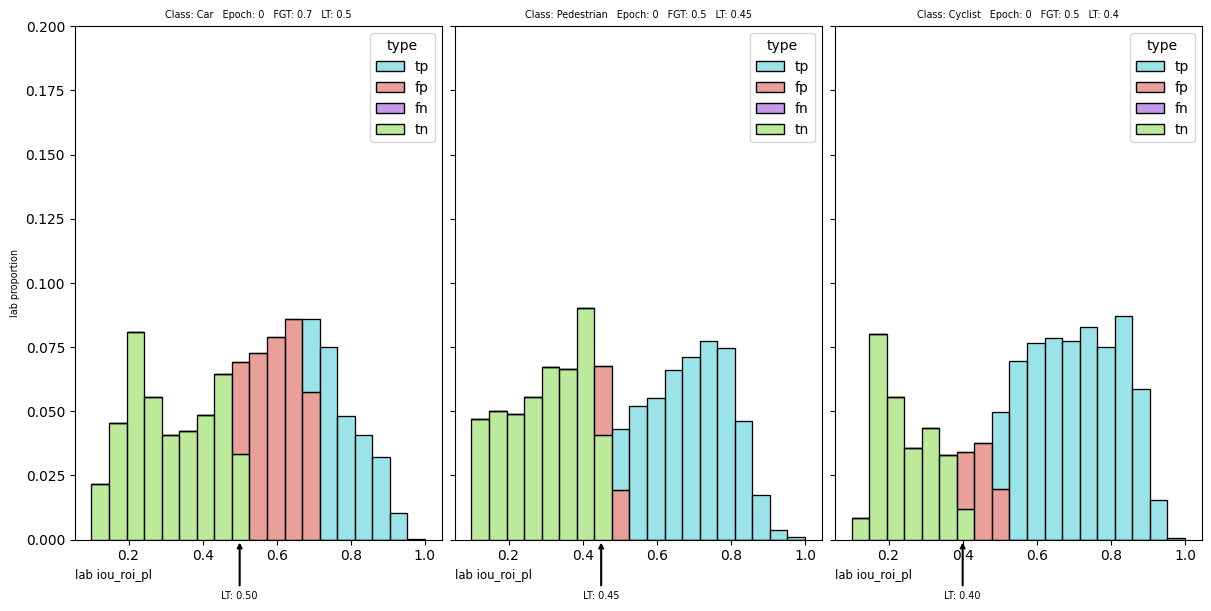

In [11]:

if ENABLE_PLOTS:
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
    stat_='proportion'
    batch_type='lab'
    update(w=0)
    plt.show()


In [12]:
# if ENABLE_PLOTS:
#     # save labeled 
#     batch_type='lab'
#     num_windows=num_windows_lab
    
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_error_hist_proportion, writer='pillow')
    
#     stat_='count'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_error_hist_count, writer='pillow')


#     # save unlabeled 
#     batch_type='unlab'
#     num_windows=num_windows_unlab
    
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_unlab_error_hist_proportion, writer='pillow')
    
#     stat_='count'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_unlab_error_hist_count, writer='pillow')

## Subsampling

In [13]:
def update(w):
    global stat_
    global batch_type

    if batch_type in ['unlab']:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_unlab, stats_afs_df_unlab, stats_df_unlab
    else:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_lab, stats_afs_df_lab, stats_df_lab
    
    if stat_ in ['proportion']:
        ARGS = SS_HIST_ARGS_PROP.copy()
        y_text = -0.02
        max_y_limit = 0.2
    elif stat_ in ['count']:
        ARGS = SS_HIST_ARGS_COUNT.copy()
        y_text = -100
        max_y_limit = 1000
    else:
        raise NotImplemented


    window_afs_df = stats_afs_df.groupby("window").get_group(w)
    window_bfs_df = stats_bfs_df.groupby("window").get_group(w)
    window_df = stats_df.groupby("window").get_group(w)

    for cind, class_name in enumerate(cls_names):
        
        iou_score_afs = window_afs_df[f'classwise_max_iou_afs_{class_name}']
        iou_score_bfs = window_bfs_df[f'classwise_max_iou_bfs_{class_name}']


        iou_score_afs = iou_score_afs[iou_score_afs>0]
        iou_score_bfs = iou_score_bfs[iou_score_bfs>0]

        classwise_local_thr = fg_pl_thresh[cind] # scalar

        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w} ', fontsize='x-small')
        sns.histplot(ax=axes[cind], data=iou_score_bfs, **ARGS, label='bfs', color=palettes['tp'] )
        sns.histplot(ax=axes[cind], data=iou_score_afs, **ARGS,  label='afs', color=palettes['fp'] )


        axes[cind].set_ylabel(f'{batch_type} {stat_}', fontsize='x-small')
        axes[cind].set_xlabel(f'{batch_type} iou_roi_pl', loc='left', fontsize='small', position=(0, 0))
        axes[cind].set_ylim(0, max_y_limit)
        axes[cind].legend(fontsize='x-small', loc='upper right')
        axes[cind].annotate(f'LT: {classwise_local_thr:.2f}', xy=(classwise_local_thr, 0), xytext=(classwise_local_thr, y_text),
                            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
                            ha='center', va='top', fontsize='x-small')
    

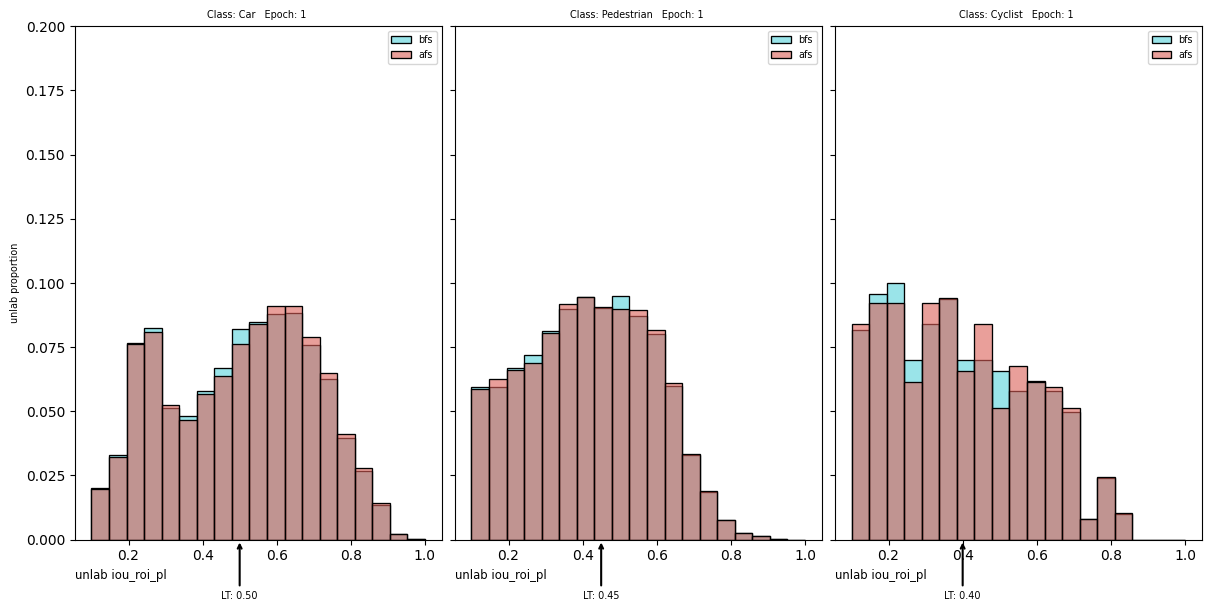

In [14]:
if ENABLE_PLOTS:
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
    stat_='proportion'
    batch_type='unlab'
    update(w=1)
    plt.show()

In [15]:
# if ENABLE_PLOTS:
#     # save labeled 
#     batch_type='lab'
#     num_windows=num_windows_lab
    
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_subsample_hist_proportion, writer='pillow')
    
#     stat_='count'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_subsample_hist_count, writer='pillow')


#     # save unlabeled 
#     batch_type='unlab'
#     num_windows=num_windows_unlab
    
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_unlab_subsample_hist_proportion, writer='pillow')
    
#     stat_='count'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_unlab_subsample_hist_count, writer='pillow')

## DIST (UNLABELED VS LABELED) iou_roi_pl

In [16]:
def update(w):
    global stat_
    global batch_type

    
    if stat_ in ['proportion']:
        ARGS = SS_HIST_ARGS_PROP.copy()
        y_text = -0.02
        max_y_limit = 0.2
    elif stat_ in ['count']:
        ARGS = SS_HIST_ARGS_COUNT.copy()
        y_text = -100
        max_y_limit = 1000
    else:
        raise NotImplemented

    window_afs_df_lab = stats_afs_df_lab.groupby("window").get_group(w)
    window_afs_df_unlab = stats_afs_df_unlab.groupby("window").get_group(w)


    for cind, class_name in enumerate(cls_names):
        
        iou_score_afs_lab = window_afs_df_lab[f'classwise_max_iou_afs_{class_name}']
        iou_score_afs_unlab = window_afs_df_unlab[f'classwise_max_iou_afs_{class_name}']


        iou_score_afs_lab = iou_score_afs_lab[iou_score_afs_lab>0]
        iou_score_afs_unlab = iou_score_afs_unlab[iou_score_afs_unlab>0]

        classwise_local_thr = fg_pl_thresh[cind] # scalar

        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w} ', fontsize='x-small')
        sns.histplot(ax=axes[cind], data=iou_score_afs_lab, **ARGS, label='lab', color=palettes['tp'] )
        sns.histplot(ax=axes[cind], data=iou_score_afs_unlab, **ARGS,  label='unlab', color=palettes['fp'] )


        axes[cind].set_ylabel(f' {stat_} ', fontsize='x-small')
        axes[cind].set_xlabel(f' iou_roi_pl ', loc='left', fontsize='small', position=(0, 0))
        axes[cind].set_ylim(0, max_y_limit)
        axes[cind].legend(fontsize='x-small', loc='upper right')
        axes[cind].annotate(f'LT: {classwise_local_thr:.2f}', xy=(classwise_local_thr, 0), xytext=(classwise_local_thr, y_text),
                            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
                            ha='center', va='top', fontsize='x-small')

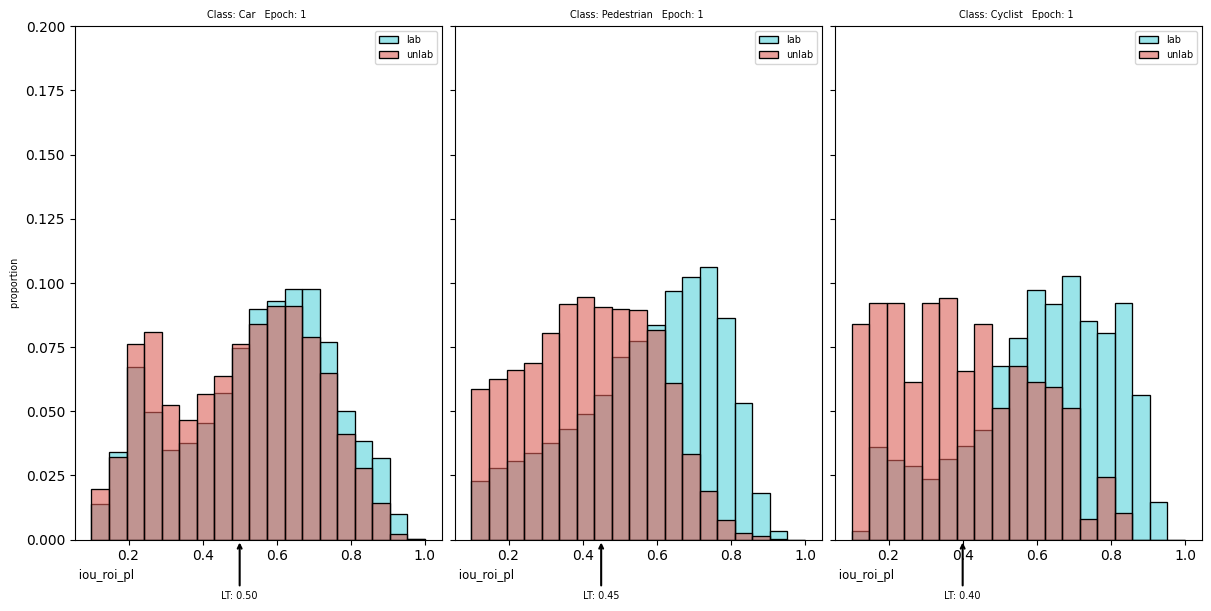

In [17]:
if ENABLE_PLOTS:
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
    stat_='proportion'
    update(w=1)
    plt.show()

In [18]:
# if ENABLE_PLOTS:
#     # save labeled vs unlabeled dist
#     num_windows=num_windows_lab
    
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_unlab_proportion, writer='pillow')
    
#     stat_='count'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_unlab_count, writer='pillow')


## With MMD

In [19]:
def update(w):
    global stat_
    global batch_type
    if stat_ in ['proportion']:
        ARGS = SS_HIST_ARGS_PROP.copy()
        y_text = -0.02
        max_y_limit = 0.2
    elif stat_ in ['count']:
        ARGS = SS_HIST_ARGS_COUNT.copy()
        y_text = -100
        max_y_limit = 1000
    else:
        raise NotImplemented

    window_afs_df_lab = stats_afs_df_lab.groupby("window").get_group(w)
    window_afs_df_unlab = stats_afs_df_unlab.groupby("window").get_group(w)

    for cind, class_name in enumerate(cls_names):
        iou_score_afs_lab = window_afs_df_lab[f'classwise_max_iou_afs_{class_name}']
        iou_score_afs_unlab = window_afs_df_unlab[f'classwise_max_iou_afs_{class_name}']

        iou_score_afs_lab = iou_score_afs_lab[iou_score_afs_lab > 0]
        iou_score_afs_unlab = iou_score_afs_unlab[iou_score_afs_unlab > 0]

        classwise_local_thr = fg_pl_thresh[cind]  # scalar

        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w}', fontsize='x-small')
        sns.histplot(ax=axes[cind], data=iou_score_afs_lab, **ARGS, label='lab', color=palettes['tp'])
        sns.histplot(ax=axes[cind], data=iou_score_afs_unlab, **ARGS, label='unlab', color=palettes['fp'])

        axes[cind].set_ylabel(f'{stat_}', fontsize='x-small')
        axes[cind].set_xlabel(f'iou_roi_pl', loc='left', fontsize='small', position=(0, 0))
        axes[cind].set_ylim(0, max_y_limit)
        axes[cind].legend(fontsize='x-small', loc='upper right')
        axes[cind].annotate(f'LT: {classwise_local_thr:.2f}', xy=(classwise_local_thr, 0), xytext=(classwise_local_thr, y_text),
                            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
                            ha='center', va='top', fontsize='x-small')

        # Perform distribution alignment
        lab_samples = torch.from_numpy(iou_score_afs_lab.values).float()
        unlab_samples = torch.from_numpy(iou_score_afs_unlab.values).float()

        # Calculate difference in means
        sigma2 = mean_diff = lab_samples.mean() - unlab_samples.mean()

        # Calculate Maximum Mean Discrepancy (MMD) or Wasserstein Distance
        lab_samples = (lab_samples - lab_samples.mean()) / lab_samples.std()  # Standardize
        unlab_samples = (unlab_samples - unlab_samples.mean()) / unlab_samples.std()  # Standardize
        mmd_dynamic = mmd_loss(lab_samples, unlab_samples, sigma2=sigma2)
        mmd_fixed = mmd_loss(lab_samples, unlab_samples, sigma2=0.25)
        axes[cind].text(0.05, 0.85, f'Mean Diff : {mean_diff:.3f}', transform=axes[cind].transAxes, fontsize='x-small')
        axes[cind].text(0.05, 0.8, f'Maximum Mean Discrepancy (Sigma: {sigma2:.2f}): {mmd_dynamic:.3f}', transform=axes[cind].transAxes, fontsize='x-small')
        axes[cind].text(0.05, 0.75, f'Maximum Mean Discrepancy (Sigma: 0.25): {mmd_fixed:.3f}', transform=axes[cind].transAxes, fontsize='x-small')
        


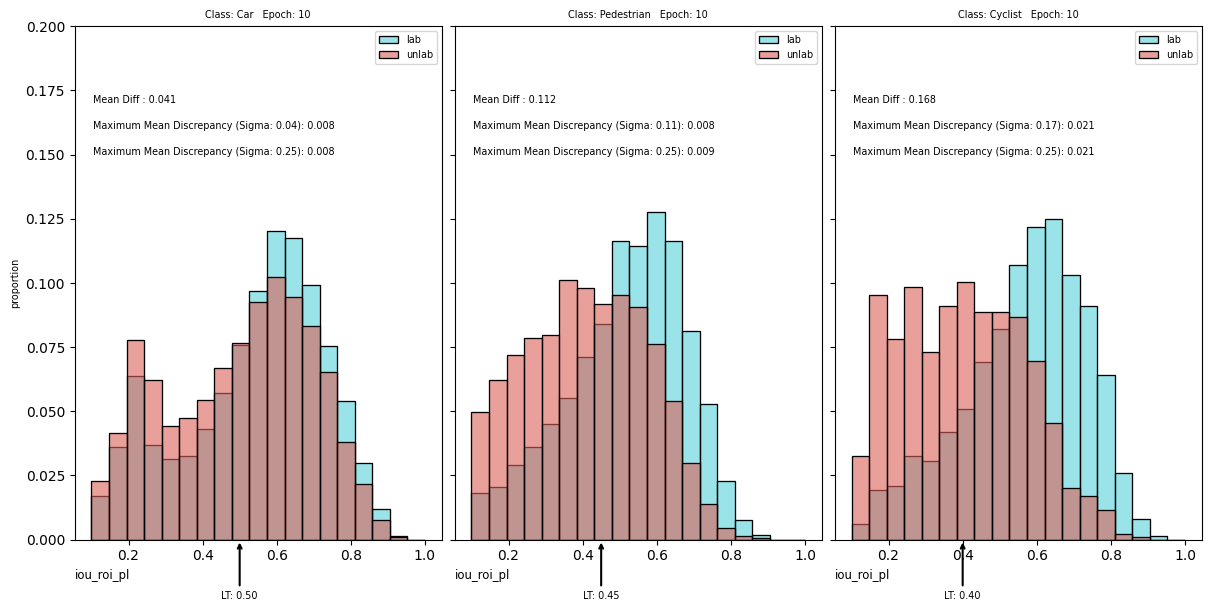

In [20]:
if ENABLE_PLOTS:
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
    stat_='proportion'
    update(w=10)
    plt.show()

In [21]:
# if ENABLE_PLOTS:
#     # save labeled vs unlabeled dist
#     num_windows=num_windows_lab
#     stat_='proportion'
#     anim = FuncAnimation(fig, update, num_windows, interval=100)
#     anim.save(anim_lab_unlab_proportion_mmd, writer='pillow')



# GMM MODELING

In [22]:
from sklearn.mixture import GaussianMixture

# can be changed for 32 samples (num_windows=45)
BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 4

stats_bfs_df_unlab, stats_afs_df_unlab, stats_df_unlab, num_windows_unlab = gather_stats(stats_unlbd, batch_type='unlab', WINDOW_SIZE=WINDOW_SIZE)
stats_bfs_df_lab, stats_afs_df_lab, stats_df_lab, num_windows_lab = gather_stats(stats_lbd, batch_type='lab', WINDOW_SIZE=WINDOW_SIZE)

ema_thr = [[] for _ in range(len(cls_names))] # iterwise saving
iter_thr = [[] for _ in range(len(cls_names))] # iterwise saving
iou_local_thresholds = np.ones((len(cls_names))) / len(cls_names)
momentum = 0.9

GMM_2 = GaussianMixture(
            n_components=2,
            weights_init=[0.5, 0.5],
            means_init=[[0.1], [0.9]],
            precisions_init=[[[1.0]], [[1.0]]],
            init_params='k-means++',
            tol=1e-9,
            max_iter=1000
        )
GMM_1 = GaussianMixture(
            n_components=1,
            weights_init=[0.5],
            means_init=[0.5],
            precisions_init=[1.0],
            init_params='k-means++',
            tol=1e-9,
            max_iter=1000
        )


In [23]:
def update(w):
    global stat_
    global ema_thr
    global iter_thr
    if batch_type in ['unlab']:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_unlab, stats_afs_df_unlab, stats_df_unlab
    else:
        stats_bfs_df, stats_afs_df, stats_df = stats_bfs_df_lab, stats_afs_df_lab, stats_df_lab
    
    if stat_ in ['proportion']:
        ARGS = SS_HIST_ARGS_PROP.copy()
        y_text = -0.02
        max_y_limit = 0.2
    elif stat_ in ['count']:
        ARGS = SS_HIST_ARGS_COUNT.copy()
        y_text = -100
        max_y_limit = 1000
    else:
        raise NotImplemented

    window_df = stats_df.groupby("window").get_group(w)
    for cind, class_name in enumerate(cls_names):
        cls_df = window_df[window_df['class_labels'] == cind+1]
        iou_score = cls_df['iou_roi_pl']
        iou_score = iou_score[iou_score > pre_filtering_thresh].to_numpy()

        iou_score = iou_score.reshape(-1, 1)

        # MODEL FITTING
        GMM_2.fit(iou_score)
        gmm_assignment = GMM_2.predict(iou_score)
        gmm_scores = GMM_2.score_samples(iou_score)

        # GET MEAN ESTIMATE OF +VE PEAK
        gmm_scores_ = gmm_scores.copy()
        gmm_scores_[gmm_assignment == 0] = -np.inf
        index = np.argmax(gmm_scores_, axis=0)
        pos_indx = ((gmm_assignment == 1) & (iou_score >= iou_score[index]).squeeze())

        if np.sum(pos_indx):
            adaptive_thr = np.min(iou_score[pos_indx])
        else:
            adaptive_thr = iou_local_thresholds[cind][-1]

        # EMA UPDATE
        iou_local_thresholds[cind] = momentum * iou_local_thresholds[cind] + (1 - momentum) * adaptive_thr

        ema_thr[cind].append(iou_local_thresholds[cind])
        iter_thr[cind].append(adaptive_thr)


        # PLOT
        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w}', fontsize='x-small')

        component_0_scores = iou_score[gmm_assignment == 0]
        component_1_scores = iou_score[gmm_assignment == 1]
        axes[cind].hist(component_0_scores, bins=ARGS['bins'], color=palettes['fp'], alpha=ARGS['alpha'], label='component 0', edgecolor='black')
        axes[cind].hist(component_1_scores, bins=ARGS['bins'], color=palettes['tp'], alpha=ARGS['alpha'], label='component 1', edgecolor='black')

        axes[cind].axvline(x=GMM_2.means_[0], color=palettes['fp'], linestyle='--', label='mu 0', alpha=0.8)
        axes[cind].axvline(x=GMM_2.means_[1], color=palettes['tp'], linestyle='--', label='mu 1', alpha=0.8)
        axes[cind].axvline(x=adaptive_thr, color=palettes['fn'], linestyle='--', label='raw thr', alpha=0.8)
        axes[cind].axvline(x=iou_local_thresholds[cind], color=palettes['tn'], linestyle='--', label='ema thr', alpha=0.8)

        axes[cind].set_ylabel(f'{batch_type} {stat_}', fontsize='x-small')
        axes[cind].set_xlabel(f'{batch_type} iou_roi_pl', loc='left', fontsize='small', position=(0, 0))
        axes[cind].legend(fontsize='x-small', loc='upper right')
        axes[cind].set_ylim(0, max_y_limit)
        axes[cind].annotate(f'LT: {iou_local_thresholds[cind]:.2f}', xy=(iou_local_thresholds[cind], 0), xytext=(iou_local_thresholds[cind], y_text),
                            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=1.5),
                            ha='center', va='top', fontsize='x-small')

        


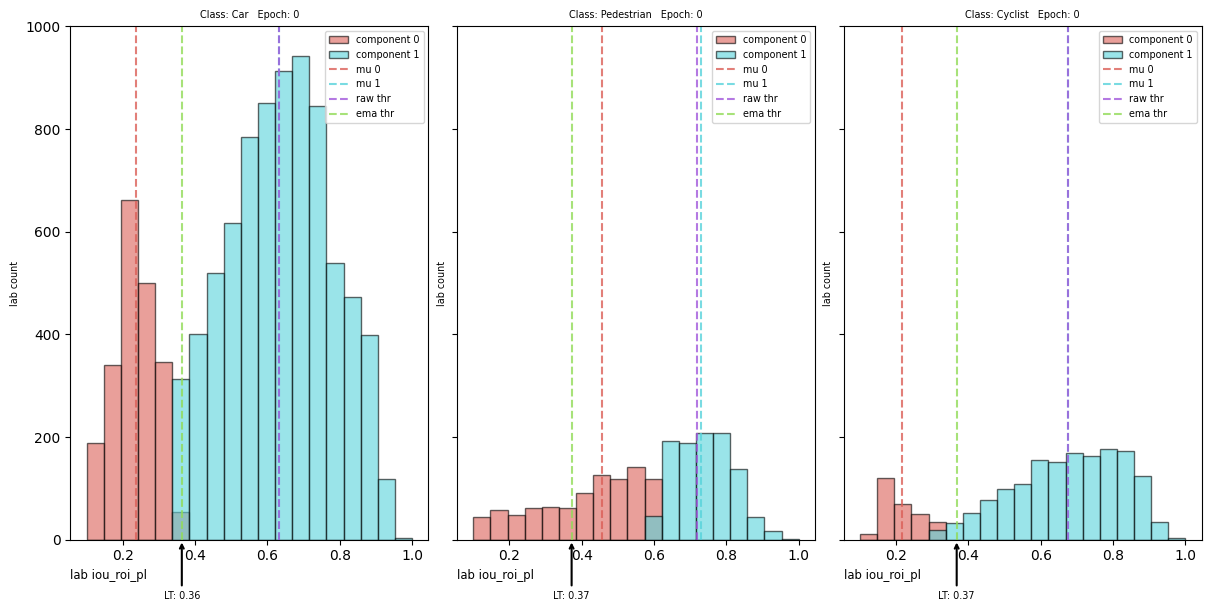

In [24]:
if ENABLE_PLOTS:
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
    stat_='count'
    batch_type='lab'
    update(w=0)
    plt.show()

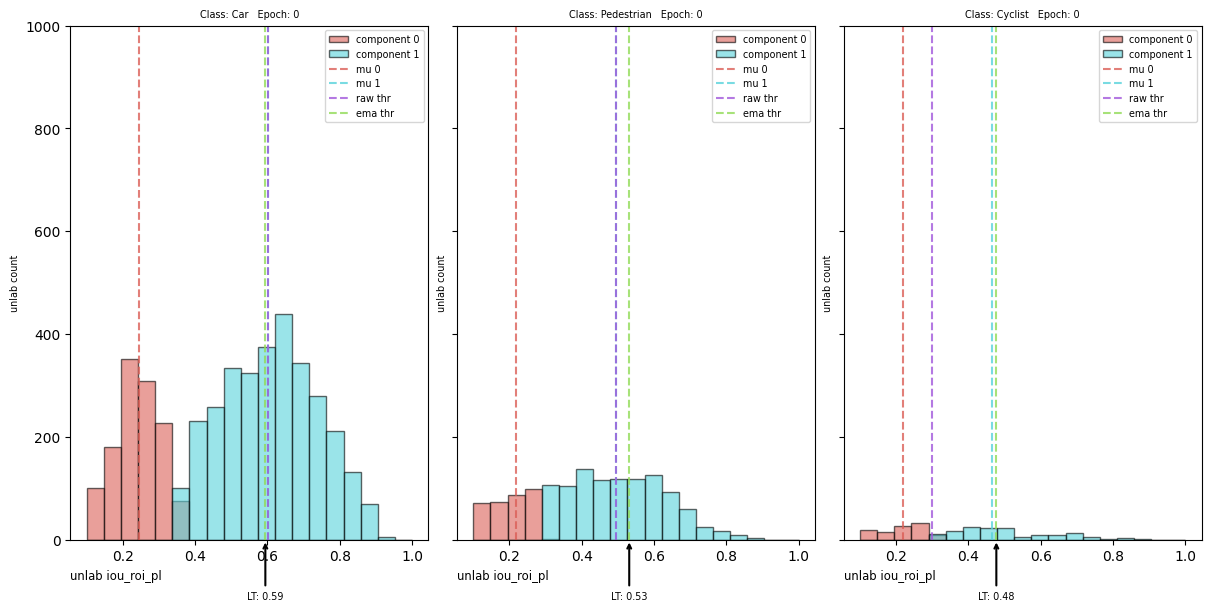

In [25]:
fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")
stat_='count'
batch_type='unlab'
num_windows = num_windows_unlab

ema_thr = [[] for _ in range(len(cls_names))] # iterwise saving
iter_thr = [[] for _ in range(len(cls_names))] # iterwise saving
iou_local_thresholds = np.ones((len(cls_names))) / len(cls_names)
momentum = 0.9

anim_unlab_iou_gmm_plot = os.path.join(SAVE_DIR, f'iou_gmm_unlab_{exp_name}_ws{WINDOW_SIZE}_plot.gif')
anim_unlab_score_gmm_plot = os.path.join(SAVE_DIR, f'score_gmm_unlab_{exp_name}_ws{WINDOW_SIZE}_plot.gif')


anim = FuncAnimation(fig, update, num_windows, interval=100)
anim.save(anim_unlab_iou_gmm_plot, writer='pillow')

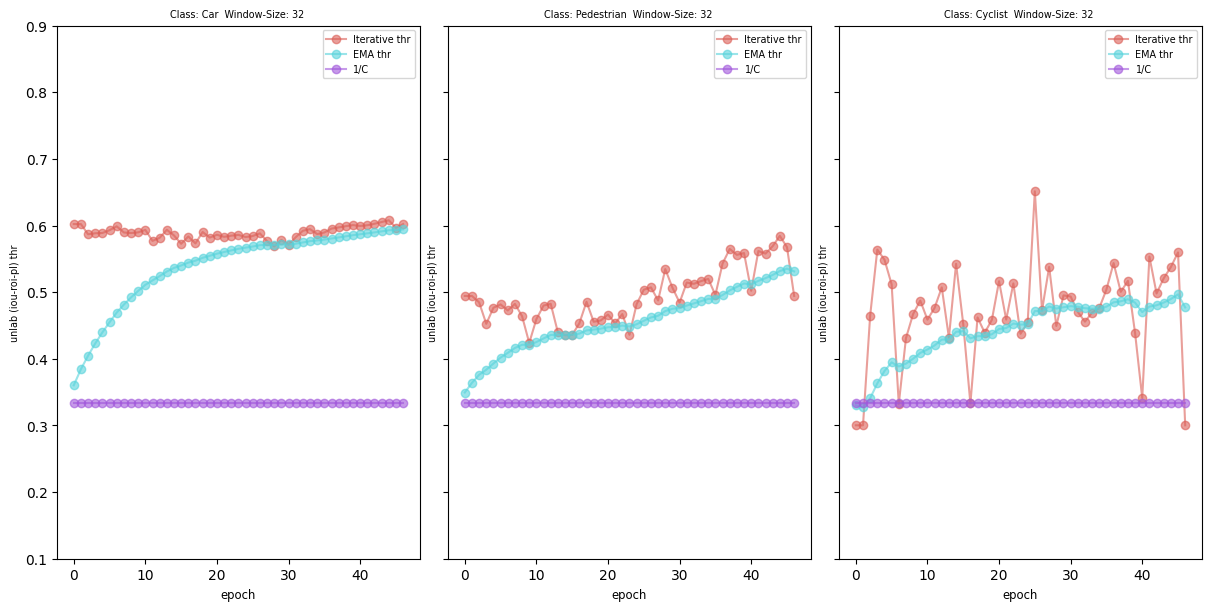

In [26]:


fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")

for cind, class_name in enumerate(cls_names):
    axes[cind].cla()
    axes[cind].set_title(f'Class: {class_name}  Window-Size: {WINDOW_SIZE} ', fontsize='x-small')

    axes[cind].plot(range(len(iter_thr[cind])), iter_thr[cind], marker='o', color=palettes['fp'], alpha=ERROR_HIST_ARGS_PROP['alpha'], label='Iterative thr')
    axes[cind].plot(range(len(iter_thr[cind])), ema_thr[cind], marker='o', color=palettes['tp'], alpha=ERROR_HIST_ARGS_PROP['alpha'], label='EMA thr')
    axes[cind].plot(range(len(iter_thr[cind])), np.ones(len(iter_thr[cind]))/len(cls_names), marker='o', color=palettes['fn'], alpha=ERROR_HIST_ARGS_PROP['alpha'], label='1/C')

    axes[cind].set_xlabel('epoch', fontsize='small')
    axes[cind].set_ylabel(f'{batch_type} (iou-roi-pl) thr', fontsize='x-small')
    axes[cind].legend(fontsize='x-small', loc='upper right')
    axes[cind].set_ylim(0.1, 0.9)





## Testing 

In [27]:
# fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")

# # Initialize lists to store performance values
# tp_values = [[] for _ in range(len(cls_names))]
# fp_values = [[] for _ in range(len(cls_names))]
# fn_values = [[] for _ in range(len(cls_names))]
# tn_values = [[] for _ in range(len(cls_names))]

# def update(w):
#     window_df = stats_df.groupby("window").get_group(w)
    
#     for cind, class_name in enumerate(cls_names):
#         cls_df = window_df[window_df['class_labels'] == cind+1]

#         gt_score = cls_df['iou_roi_gt']
#         iou_score = cls_df['iou_roi_pl']

#         classwise_fg_thr = fg_gt_thresh[cind] # scalar
#         classwise_local_thr = fg_pl_thresh[cind] # scalar

#         tp_mask = (gt_score >= classwise_fg_thr) & (iou_score >= classwise_local_thr)
#         fp_mask = (gt_score < classwise_fg_thr) & (iou_score >= classwise_local_thr)
#         fn_mask = (gt_score >= classwise_fg_thr) & (iou_score < classwise_local_thr)
#         tn_mask = (gt_score < classwise_fg_thr) & (iou_score < classwise_local_thr)

#         cls_df.loc[tp_mask, 'type'] = 'tp'
#         cls_df.loc[fp_mask, 'type'] = 'fp'
#         cls_df.loc[fn_mask, 'type'] = 'fn'
#         cls_df.loc[tn_mask, 'type'] = 'tn'
        
#         # Accumulate TP, FP, FN, TN counts for the epoch
#         tp_epoch = tp_mask.sum()
#         fp_epoch = fp_mask.sum()
#         fn_epoch = fn_mask.sum()
#         tn_epoch = tn_mask.sum()
        
#         # Store performance values for the class
#         tp_values[cind].append(tp_epoch)
#         fp_values[cind].append(fp_epoch)
#         fn_values[cind].append(fn_epoch)
#         tn_values[cind].append(tn_epoch)
        
#         axes[cind].cla()
#         axes[cind].plot(tp_values[cind], label='tp', color=palettes['tp'], linewidth=2)
#         axes[cind].plot(fp_values[cind], label='fp', color=palettes['fp'], linewidth=2)
#         axes[cind].plot(fn_values[cind], label='fn', color=palettes['fn'])
#         axes[cind].plot(tn_values[cind], label='tn', color=palettes['tn'])
#         axes[cind].set_title(f'Class: {class_name}   Epoch: {w}   FGT: {classwise_fg_thr}   LT: {classwise_local_thr}', fontsize='x-small')
#         axes[cind].set_xlabel('Epoch', fontsize='small')
#         axes[cind].set_ylabel('Count', fontsize='x-small')
#         axes[cind].legend(fontsize='x-small', loc='upper right')


#         axes[cind].plot(len(tp_values[cind]) - 1, tp_epoch, marker='o', markersize=6, color=palettes['tp'])
#         axes[cind].plot(len(fp_values[cind]) - 1, fp_epoch, marker='o', markersize=6, color=palettes['fp'])
#         axes[cind].plot(len(fn_values[cind]) - 1, fn_epoch, marker='o', markersize=6, color=palettes['fn'])
#         axes[cind].plot(len(tn_values[cind]) - 1, tn_epoch, marker='o', markersize=6, color=palettes['tn'])

#         axes[cind].set_xlim(0, 60)
#         axes[cind].set_ylim(0, 20000)
# if ENABLE_PLOTS:
#     anim = FuncAnimation(fig, update, num_windows, interval=60)
#     anim.save(anim_error_plot, writer='pillow')

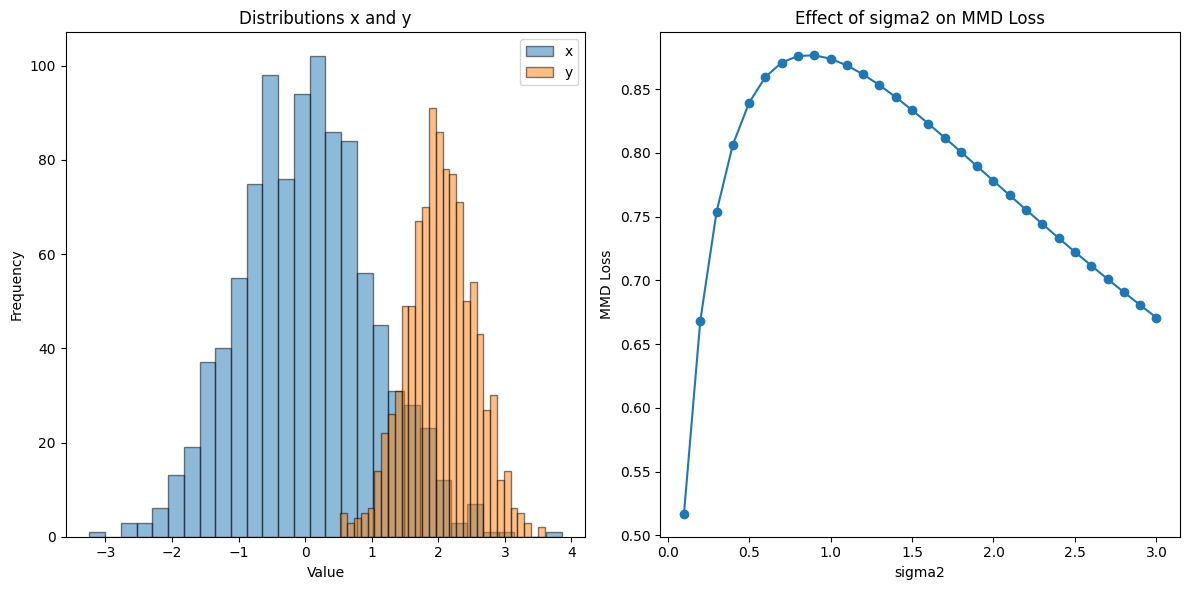

In [28]:

# Generate dummy data
np.random.seed(42)
x = np.random.normal(loc=0, scale=1, size=1000)
y = np.random.normal(loc=2, scale=0.5, size=1000)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

# Varying sigma2 values
sigma2_values = np.arange(0, 3.1, 0.1)
loss_values = []

# Compute MMD loss for each sigma2 value
for sigma2 in sigma2_values:
    loss = mmd_loss(x, y, sigma2)
    loss_values.append(loss.item())

# Plotting
plt.figure(figsize=(12, 6))

# Plot distributions x and y
plt.subplot(1, 2, 1)
plt.hist(x.numpy(), bins=30, alpha=0.5, label='x',edgecolor='black')
plt.hist(y.numpy(), bins=30, alpha=0.5, label='y', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distributions x and y')
plt.legend()

# Plot MMD loss
plt.subplot(1, 2, 2)
plt.plot(sigma2_values, loss_values, marker='o')
plt.xlabel('sigma2')
plt.ylabel('MMD Loss')
plt.title('Effect of sigma2 on MMD Loss')

plt.tight_layout()
plt.show()


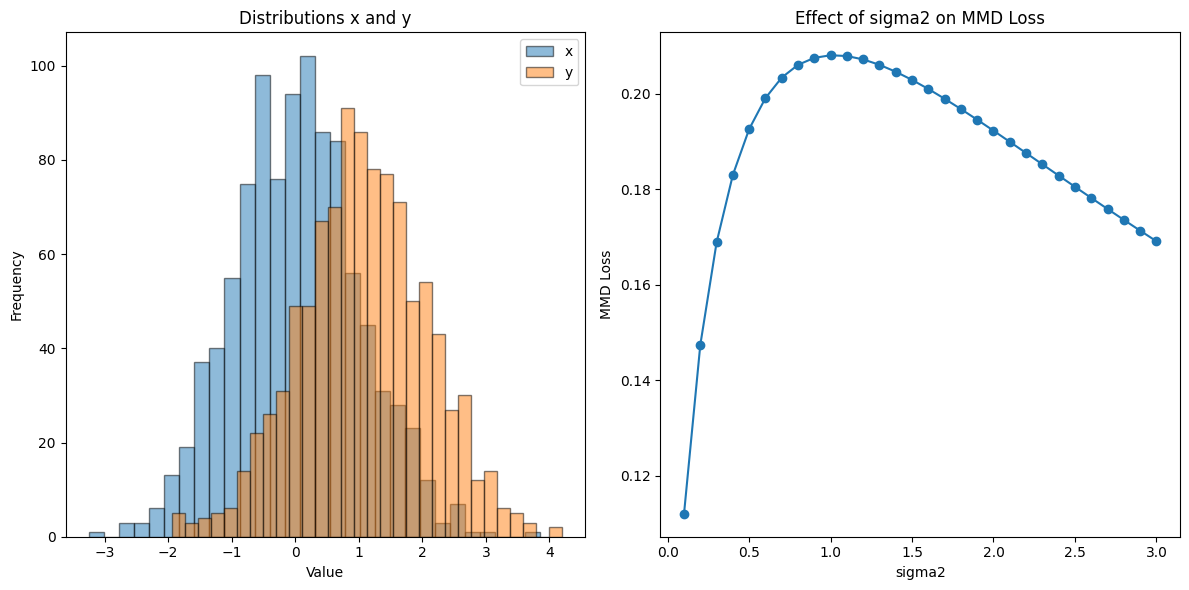

In [29]:

# Generate dummy data
np.random.seed(42)
x = np.random.normal(loc=0, scale=1, size=1000)
y = np.random.normal(loc=1, scale=1, size=1000)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

# Varying sigma2 values
sigma2_values = np.arange(0, 3.1, 0.1)
loss_values = []

# Compute MMD loss for each sigma2 value
for sigma2 in sigma2_values:
    loss = mmd_loss(x, y, sigma2)
    loss_values.append(loss.item())

# Plotting
plt.figure(figsize=(12, 6))

# Plot distributions x and y
plt.subplot(1, 2, 1)
plt.hist(x.numpy(), bins=30, alpha=0.5, label='x',edgecolor='black')
plt.hist(y.numpy(), bins=30, alpha=0.5, label='y', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distributions x and y')
plt.legend()

# Plot MMD loss
plt.subplot(1, 2, 2)
plt.plot(sigma2_values, loss_values, marker='o')
plt.xlabel('sigma2')
plt.ylabel('MMD Loss')
plt.title('Effect of sigma2 on MMD Loss')

plt.tight_layout()
plt.show()
